## Generate intial word embedding for headlines and description

- The embedding is limited to a fixed vocabulary size (`vocab_size`) but a vocabulary of all the words that appeared in the data is built.

- Specify FN0 and FN_lines to correctly use the pickle file in pickles folder. This pickle file should have been generated by load_data.

In [105]:
FN = 'vocabulary-embedding'

In [106]:
seed = 42

In [107]:
vocab_size = 40000 # vocab size in GloVe

In [108]:
embedding_dim = 100

In [109]:
lower = True # whether to lowercase the text

# Read tokenized headlines and descriptions

In [110]:
import pickle
FN0 = 'all-the-news' # this is the name of the data file which I assume you already have
FN_lines = 1000
with open('pickles/%s_%s.pickle'%(FN0, FN_lines), 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [111]:
n_sentences = 5

In [112]:
if lower:
    heads = [h[0] for h in heads]

In [113]:
if lower:
    desc = [' '.join(h[:n_sentences]).lower() for h in desc]

In [114]:
i=0
heads[i]

'House Republicans Fret About Winning Their Health Care Suit The New York Times'

In [115]:
desc[i]

'congressional republicans have a new fear when it come to their health care lawsuit against the obama administration they might win the incoming trump administration could choose to no longer defend the executive branch against the suit which challenge the administration s authority to spend billion of dollar on health insurance subsidy for and americans handing house republicans a big victory on issue but a sudden loss of the disputed subsidy could conceivably cause the health care program to implode leaving million of people without access to health insurance before republicans have prepared a replacement that could lead to chaos in the insurance market and spur a political backlash just a republicans gain full control of the government to stave off that outcome republicans could find themselves in the awkward position of appropriating huge sum to temporarily prop up the obama health care law angering conservative voter who have been demanding an end to the law for year'

In [116]:
# keywords[i]

In [117]:
len(heads),len(set(heads))

(998, 993)

In [118]:
len(desc),len(set(desc))

(998, 987)

# Build vocabulary from given pickle file

In [119]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [120]:
vocab, vocabcount = get_vocab(heads+desc)

In [121]:
print('Most Popular Tokens:')
print(list(vocab)[:50])
print('...',len(list(vocab)))


Most Popular Tokens:
['the', 'a', 'of', 'to', 'and', 'in', 's', 'on', 'that', 'for', 'it', 'The', 'New', 'York', 'wa', 'Times', 'his', 'with', 'trump', 'mr', 'is', 'at', 'by', 'he', 'from', 'an', 'said', 'president', 'had', 'but', 'ha', 'who', 'have', 'be', 'her', 'not', 'new', 'are', 'year', 'one', 'been', 'about', 'were', 'or', 'more', 'their', 'they', 'this', 'she', 'after']
... 16180


Text(0,0.5,'total appearances')

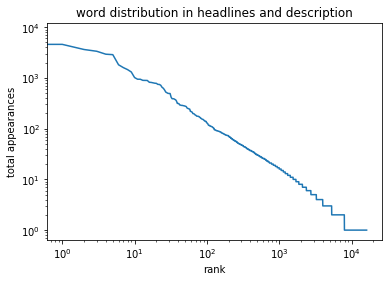

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and description')
plt.xlabel('rank')
plt.ylabel('total appearances')

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [123]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [124]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [125]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## Read GloVe

In [126]:
from keras.utils.data_utils import get_file
import os

# Since we are using GloVe, we use the text file that matches the dimension specified at the top of this file
# GloVe.6B has dimensions = 50/100/200/300
fname = 'glove.6B.%dd.txt'%embedding_dim
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))

if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')

glove_name = os.path.join(datadir, fname)

if not os.path.exists(glove_name):
    # If the specified text file does not exist, we assume that the glove.6B.zip file has not been downloaded
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")   
    # Run unzip shell command to extract glove.6B.zip into ~/.keras/datasets
    !unzip {path} -d {datadir}

In [127]:
glove_n_symbols = !wc -l {glove_name} # Line counts in glove_name (essentially the vocabulary size)
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [128]:
import numpy as np

glove_index_dict = {} # Keeps track of the index corresponding to each word in the vocabulary
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim)) # Saves vector representation for each word, ordered by its index
globale_scale = .1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        # Each line in glove text file is the following format: { word vector-representation }
        l = l.strip().split() # strip and split each line separated by spaces
        w = l[0] # w is the first column in each line
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale 

In [129]:
glove_embedding_weights.std()

0.04081572760019029

In [130]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## Embedding Matrix

Use GloVe to initialize embedding matrix

In [131]:
# Generate random embedding with same scale as glove
np.random.seed(seed)
shape = (len(idx2word), embedding_dim)
# TO-DO: Scale -- why?
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# Copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
for i in range(len(idx2word)):
    w = idx2word[i] # Word at the i-th index in idx2word
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower())) # The corresponding index of w in glove_index_dict
    if g is not None:
        # Populate the weights for the corresponding words into embedding if the word occurs in glove
        embedding[i,:] = glove_embedding_weights[g,:]
        c += 1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04079858385001259
number of tokens, in small vocab, found in glove and copied to embedding 15924 0.3981


#### Lots of words in the full vocabulary (word2idx) are not found in GloVe vocabulary:
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [132]:
glove_thr = 0.5

In [133]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

For every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [134]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 0


manually check that the worst substitutions we are going to do are good enough

In [135]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

build a lookup table of index of outside words to index of inside words

In [136]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [137]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

998

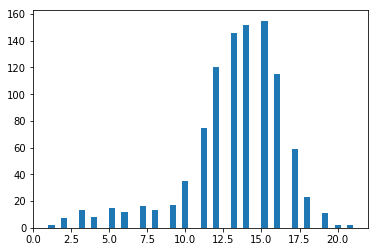

In [138]:
plt.hist(list(map(len,Y)),bins=50);

In [139]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

998

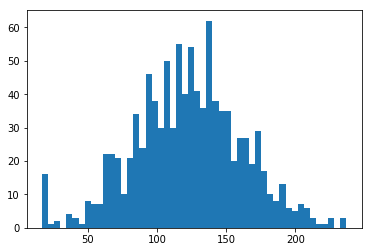

In [140]:
plt.hist(list(map(len,X)),bins=50);

In [141]:
with open('data/%s-%s-vocab-embedding.pickle'%(FN0, FN_lines),'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [142]:
with open('data/%s-%s-vocab-embedding.data.pickle'%(FN0, FN_lines),'wb') as fp:
    pickle.dump((X,Y),fp,-1)

In [143]:
print('Vocabulary embedding completed!')

Vocabulary embedding completed!
